In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
import pandas as pd
PRIMARY = 'Category Name'
SECONDARY = 'Customer State'

df = pd.read_csv(
    'DataCoSupplyChainDataset.csv', 
    usecols = [PRIMARY, SECONDARY], 
    encoding = 'unicode_escape'
).apply(lambda col: col.str.strip())
df.head()

,Category Name,Customer State
0,Sporting Goods,PR
1,Sporting Goods,PR
2,Sporting Goods,CA
3,Sporting Goods,CA
4,Sporting Goods,PR


# Check & remove null + duplicate values

In [3]:
df.isnull().sum().sort_values(ascending=False)

Category Name     0
Customer State    0
dtype: int64

In [4]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 170097
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category Name   1751 non-null   object
 1   Customer State  1751 non-null   object
dtypes: object(2)
memory usage: 41.0+ KB


# Convert DataFrame to Graphs

In [5]:
primary_col, secondary_col = df[PRIMARY], df[SECONDARY]
print(f'Number of {PRIMARY}:', primary_col.nunique())
print(f'Number of {SECONDARY}:', secondary_col.nunique())
print('Number of edges:', len(df))

Number of Category Name: 50
Number of Customer State: 46
Number of edges: 1751


## 1. Bipartite Graph

In [6]:
import networkx as nx
from networkx.algorithms import bipartite

B = nx.Graph()
for index, row in df.iterrows():
    B.add_edge(row[PRIMARY], row[SECONDARY], weight=1)

B.add_nodes_from(primary_col, bipartite=0)
B.add_nodes_from(secondary_col, bipartite=1)    

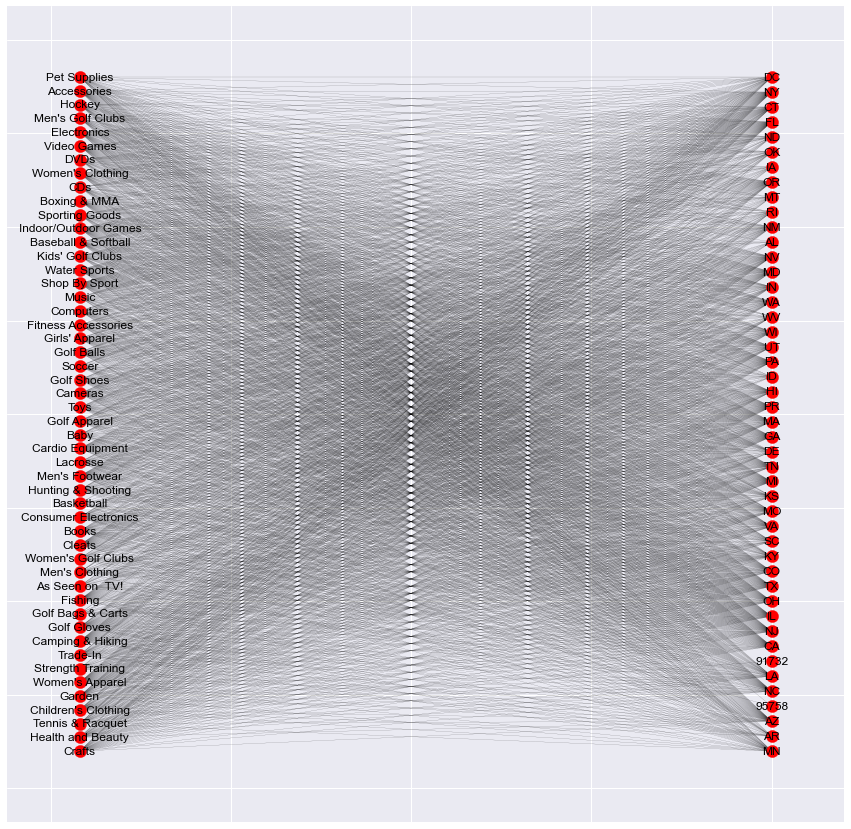

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
pos = nx.drawing.layout.bipartite_layout(B, primary_col)
nx.draw_networkx(B, pos=pos, node_size=150, width=0.1, node_color='red')

## 2. Weighted Projected Graph

In [8]:
G = bipartite.weighted_projected_graph(B, primary_col)
node_labels = dict(zip(primary_col, primary_col))

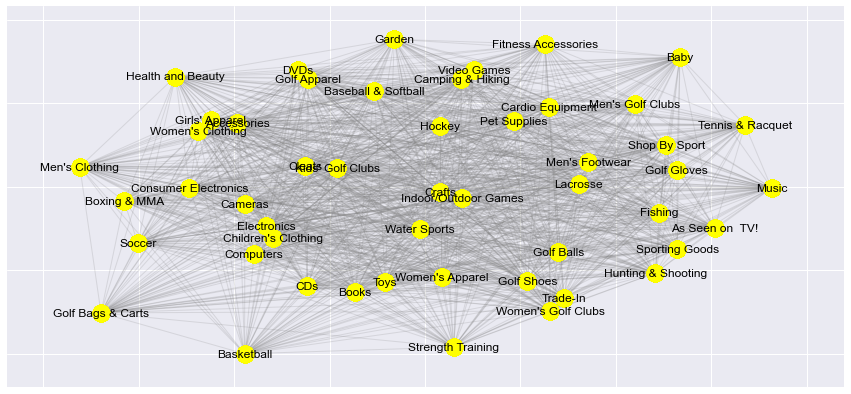

In [9]:
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=primary_col, node_color='yellow')
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# Community Detection

In [10]:
df_groupby_category = df.groupby([SECONDARY])[PRIMARY].apply(lambda x: sorted(set(x)))
df_groupby_category = df_groupby_category.reset_index()
# print(df_groupby_category.iloc[14][1])
df_groupby_category.head()

,Customer State,Category Name
0,91732,[Children's Clothing]
1,95758,"[Consumer Electronics, Video Games]"
2,AL,"[Camping & Hiking, Cardio Equipment, Cleats, C..."
3,AR,"[Cameras, Camping & Hiking, Cardio Equipment, ..."
4,AZ,"[Accessories, Baby, Baseball & Softball, Baske..."


In [11]:
def get_cluster_common_values(cluster):
    commons = []
    for index, row in df_groupby_category.iterrows():
        if set(cluster).issubset(row[PRIMARY]):
            commons.append(row[SECONDARY])
    return commons

In [12]:
def print_communities(node_groups):
    print('Number of communities:', len(node_groups))
    for index, cluster in enumerate(node_groups):
        common_values = get_cluster_common_values(cluster)
        print(f'\nCluster {index}:')
        print(f"- {len(cluster)} Nodes: {', '.join(cluster)}")
        print(f"- {len(common_values)} Common values: {', '.join(common_values)}")

## 1. Louvain Algorithm

In [13]:
import community.community_louvain as community_louvain
from collections import defaultdict
partition = community_louvain.best_partition(G)
louvain_node_groups = [[] for _ in set(partition.values())]

for node, cluster in sorted(partition.items()):
    louvain_node_groups[cluster].append(node)
print_communities(louvain_node_groups)

Number of communities: 2

Cluster 0:
- 25 Nodes: Accessories, Books, Cameras, Camping & Hiking, Cardio Equipment, Children's Clothing, Cleats, Computers, Consumer Electronics, Crafts, Electronics, Fishing, Garden, Golf Apparel, Golf Balls, Golf Gloves, Golf Shoes, Indoor/Outdoor Games, Kids' Golf Clubs, Men's Footwear, Shop By Sport, Video Games, Water Sports, Women's Apparel, Women's Clothing
- 23 Common values: AZ, CA, CO, CT, FL, GA, HI, IL, LA, MA, MD, MI, MO, NC, NJ, NV, NY, OH, OR, PA, PR, TN, TX

Cluster 1:
- 25 Nodes: As Seen on  TV!, Baby, Baseball & Softball, Basketball, Boxing & MMA, CDs, DVDs, Fitness Accessories, Girls' Apparel, Golf Bags & Carts, Health and Beauty, Hockey, Hunting & Shooting, Lacrosse, Men's Clothing, Men's Golf Clubs, Music, Pet Supplies, Soccer, Sporting Goods, Strength Training, Tennis & Racquet, Toys, Trade-In, Women's Golf Clubs
- 8 Common values: CA, FL, GA, IL, MI, NY, PR, TX


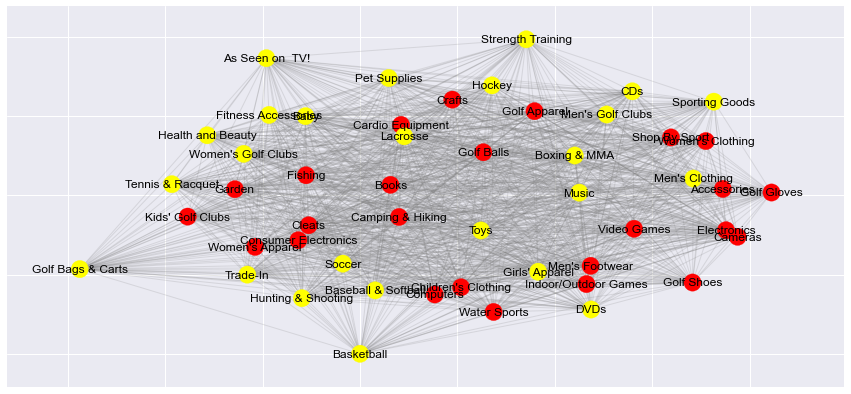

In [14]:
import matplotlib.cm as cm
cmap = cm.get_cmap('autumn', max(partition.values()) + 1)
pos = nx.spring_layout(G)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(G, pos, partition.keys(), cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos)
plt.show()

## 2. Girvan Newman Algorithm

In [15]:
from networkx.algorithms.community.centrality import girvan_newman
communities = girvan_newman(G)
gn_node_groups = []

for com in next(communities):
    gn_node_groups.append(sorted(com))
print_communities(gn_node_groups)

Number of communities: 2

Cluster 0:
- 1 Nodes: Sporting Goods
- 31 Common values: AZ, CA, CO, CT, DE, FL, GA, HI, IL, IN, LA, MA, MD, MI, MN, MO, MT, NC, ND, NJ, NY, OH, OR, PA, PR, TN, TX, UT, VA, WA, WI

Cluster 1:
- 49 Nodes: Accessories, As Seen on  TV!, Baby, Baseball & Softball, Basketball, Books, Boxing & MMA, CDs, Cameras, Camping & Hiking, Cardio Equipment, Children's Clothing, Cleats, Computers, Consumer Electronics, Crafts, DVDs, Electronics, Fishing, Fitness Accessories, Garden, Girls' Apparel, Golf Apparel, Golf Bags & Carts, Golf Balls, Golf Gloves, Golf Shoes, Health and Beauty, Hockey, Hunting & Shooting, Indoor/Outdoor Games, Kids' Golf Clubs, Lacrosse, Men's Clothing, Men's Footwear, Men's Golf Clubs, Music, Pet Supplies, Shop By Sport, Soccer, Strength Training, Tennis & Racquet, Toys, Trade-In, Video Games, Water Sports, Women's Apparel, Women's Clothing, Women's Golf Clubs
- 8 Common values: CA, FL, GA, IL, MI, NY, PR, TX


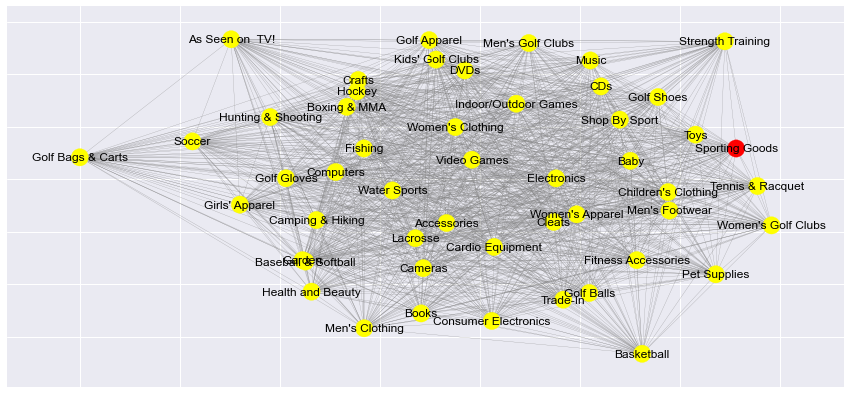

In [16]:
color_map = []    
for node in G:
    color_map.append('red' if node in gn_node_groups[0] else 'yellow')
    
plt.figure(figsize=(15, 7))    
nx.draw_networkx(G, node_color=color_map, edge_color='grey', width=0.2)
plt.show()

## 3. K-Means Algorithm

In [47]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
adj_matrix = nx.to_numpy_array(G)
adj_matrix

array([[ 0., 31., 31., ..., 30., 31., 31.],
       [31.,  0., 44., ..., 35., 44., 44.],
       [31., 44.,  0., ..., 35., 44., 44.],
       ...,
       [30., 35., 35., ...,  0., 35., 35.],
       [31., 44., 44., ..., 35.,  0., 44.],
       [31., 44., 44., ..., 35., 44.,  0.]])

In [42]:
import numpy as np
distortions = []
K = range(1, 8)

for k in K:
    kmean_model = KMeans(n_clusters=k)
    kmean_model.fit(adj_matrix)
    dist = sum(np.min(cdist(adj_matrix, kmean_model.cluster_centers_, 'euclidean'), axis=1))
    distortions.append(dist / adj_matrix.shape[0])

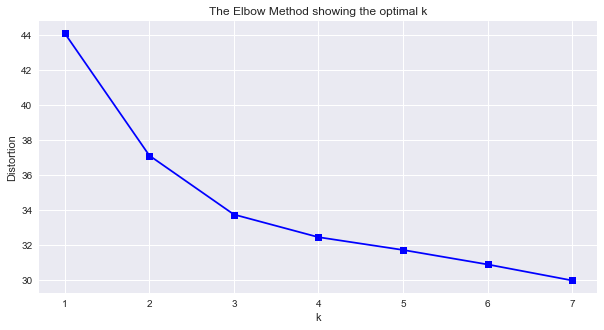

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bs-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [44]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(adj_matrix)
kmeans_node_groups = [[] for _ in range(kmeans.n_clusters)]
 
for node, cluster in zip(G.nodes(), kmeans.labels_):
    kmeans_node_groups[cluster].append(node)
print_communities(kmeans_node_groups)

Number of communities: 3

Cluster 0:
- 24 Nodes: Sporting Goods, Boxing & MMA, Trade-In, Kids' Golf Clubs, Hunting & Shooting, Baseball & Softball, Consumer Electronics, Soccer, Crafts, Tennis & Racquet, Fitness Accessories, Lacrosse, Baby, Books, DVDs, CDs, Hockey, Pet Supplies, Health and Beauty, Music, Golf Apparel, Women's Golf Clubs, Men's Golf Clubs, Toys
- 14 Common values: AZ, CA, FL, GA, IL, MI, NC, NJ, NY, OH, OR, PA, PR, TX

Cluster 1:
- 5 Nodes: Basketball, Men's Clothing, As Seen on  TV!, Strength Training, Golf Bags & Carts
- 8 Common values: CA, FL, GA, IL, MI, NY, PR, TX

Cluster 2:
- 21 Nodes: Cleats, Shop By Sport, Women's Apparel, Electronics, Cardio Equipment, Men's Footwear, Camping & Hiking, Cameras, Computers, Girls' Apparel, Accessories, Women's Clothing, Golf Balls, Children's Clothing, Fishing, Garden, Video Games, Golf Gloves, Golf Shoes, Water Sports, Indoor/Outdoor Games
- 28 Common values: AZ, CA, CO, CT, FL, GA, HI, IL, IN, LA, MA, MD, MI, MN, MO, NC, NJ,

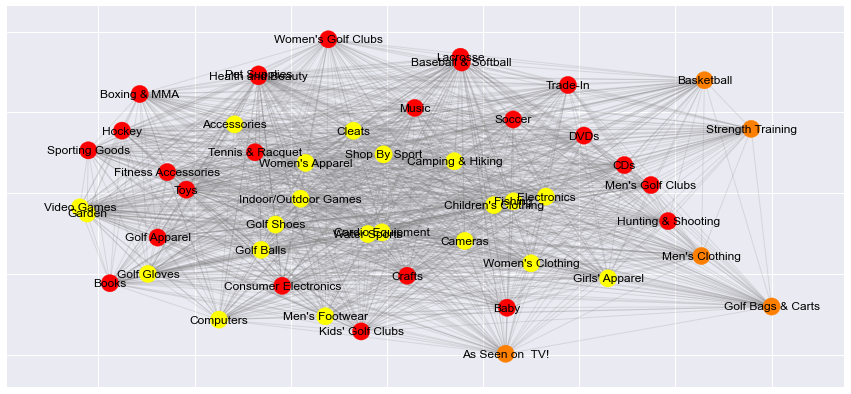

In [52]:
cmap = cm.get_cmap('autumn', max(kmeans.labels_) + 1)
pos = nx.spring_layout(G)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(G, pos, G.nodes(), cmap=cmap, node_color=kmeans.labels_)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos)
plt.show()

# Network Centrality

In [22]:
# Degree Centrality
# Betweenness Centrality
# Closeness Centrality
# Eigenvector Centrality
# PageRank